### SpaCy with coreference and compound processing
https://medium.com/inspiredbrilliance/knowledge-graphs-from-complex-text-eb009aeed48e


The sample file sample.docx is converted from selected section from Cloud Computing as html

In [ ]:
!pip install coreferee
!pip install spacy-transformers
!pip install python-docx #<-- Yes you can directly install in Colab
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_trf
!python -m coreferee install en
!python -m spacy download en_core_web_md


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.6/182.6 kB 3.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184505 sha256=44415b

In [ ]:
import spacy
import coreferee
import spacy_transformers

def coref_resolve(text):
    nlp1 = spacy.load('en_core_web_trf')
    nlp1.add_pipe('coreferee')
    doc1 = nlp1(text)
    tok_list = list(token.text for token in doc1)
    c = 0
    for chain in doc1._.coref_chains:
        for mention in chain:
            res1 = [doc1._.coref_chains.resolve(doc1[i]) for i in mention]
            res = list(filter((None).__ne__, res1))
            if len(res) != 0:
                if len(res[0]) == 1:
                    tok_list[mention[0] + c] = str(res[0][0])
                elif len(res[0]) > 1:
                    tok_list[mention[0] + c] = str(res[0][0])
                    for j in range(1, len(res[0])):
                        tok_list.insert(mention[0] + c + j, str(res[0][j]))
                        c = c + 1
    textres = " ".join(tok_list)
    return textres

In [ ]:
def getText(docObject):
    fullText = []
    for para in docObject.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)



In [ ]:
nlp = spacy.load('en_core_web_md')

def compound_to_simple(sentence):
    doc = nlp(sentence)
    
    root_token = None
    for token in doc:
        if (token.dep_ == "ROOT"):
            root_token = token
            
    other_verbs = []
    for token in doc:
        ancestors = list(token.ancestors)
        if (token.pos_ == "VERB" and len(ancestors) < 3 and token != root_token):
            other_verbs.append(token)
            
    token_spans = []
    all_verbs = [root_token] + other_verbs
    for other_verb in all_verbs:
        first_token_index = len(doc)
        last_token_index = 0
        this_verb_children = list(other_verb.children)
        for child in this_verb_children:
            if (child not in all_verbs):
                if (child.i < first_token_index):
                    first_token_index = child.i
                if (child.i > last_token_index):
                    last_token_index = child.i
        token_spans.append((first_token_index, last_token_index))
        
    sentence_clauses = []
    for token_span in token_spans:
        start = token_span[0]
        end = token_span[1]
        if (start < end):
            clause = doc[start:end]
            sentence_clauses.append(clause)
    sentence_clauses = sorted(sentence_clauses, key=lambda tup: tup[0])
    clauses_text = [clause.text for clause in sentence_clauses]
    return clauses_text

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
from spacy.matcher import Matcher 

def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None)

  matches = matcher(doc)
  k = len(matches) - 1

  if k == -1:
    return " "

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
#Import the tools
import docx
import pandas as pd
import numpy as np
# from google.colab import files
from tqdm import tqdm
import glob
# uploaded = files.upload() #<-- Select the file you want to upload

ModuleNotFoundError: ignored

In [ ]:
testfilelist = glob.glob('/content/drive/MyDrive/MSCS Project/CS298_spring23/data/docx/1-*.docx')

In [ ]:
file_name = '2-1.docx' #<-- Change filename to your file
doc = docx.Document(file_name)

In [ ]:
coref_text = coref_resolve(getText(doc))

In [ ]:
compound_text = compound_to_simple(coref_text)

In [ ]:
cleaned = []
for i in range(len(compound_text)):
  t = compound_text[i].replace('\n','')
  t = t.replace('\xa0','')
  cleaned.append(t)
print(cleaned)

['As demonstrated', ', the ability to work in parallel as a group represents a very efficient way  to reach a common target ; human beings have learned to aggregate beings and to assemble  man - made devices in organizations in which each entity may have modest ability ,', 'to work in parallel as a group', 'to aggregate beings', 'to assemble  man - made devices', 'network of entities can organize beings to accomplish goals that an individual entity can not', 'to accomplish goals', 'that the thought that individual systems should work in concert to solve complex  applications was formulated early on', 'computing allows us to solve large problems by splitting problems into smaller ones and solving  problems concurrently', 'us to solve large problems', 'computing was considered for many years the “ holy', ';  science required major advances in several areas , including algorithms , programming languages and environments ,  performance monitoring , computer architecture , interconnection n

In [ ]:
from tqdm import tqdm

entity_pairs = []
relations = []
for i in tqdm(cleaned):
  entity_pairs.append(get_entities(i))
  r = get_relation(i)
  if r:
    relations.append(r)


100%|██████████| 109/109 [00:04<00:00, 26.48it/s]


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

rel = [r for r in relations]

kg_df = pd.DataFrame({'source':source, 'edge':relations, 'target':target})


In [ ]:
kg_df['source'] = kg_df['source'].replace('', np.nan)
kg_df['source'] = kg_df['source'].replace(' ', np.nan)
kg_df['target'] = kg_df['target'].replace('', np.nan)
kg_df['target'] = kg_df['target'].replace(' ', np.nan)
kg_df['edge'] = kg_df['edge'].replace(' ', np.nan)
kg_df['edge'] = kg_df['edge'].replace('', np.nan)



In [ ]:
df = kg_df.dropna(axis="rows")


In [ ]:
df.head(21)

,source,edge,target
1,made entity,learned,modest ability
5,that,can,goals
7,complex applications,formulated,concert
8,us,allows,smaller problems
9,us,solve large,large problems
10,computing,considered for many,many years
11,science,required major,several algorithms
12,us,allow,same solution
13,us,solve,single system
15,general speed up,defined as,parallel S(N


In [ ]:
df.to_csv('/content/drive/MyDrive/MSCS Project/2-1.csv')

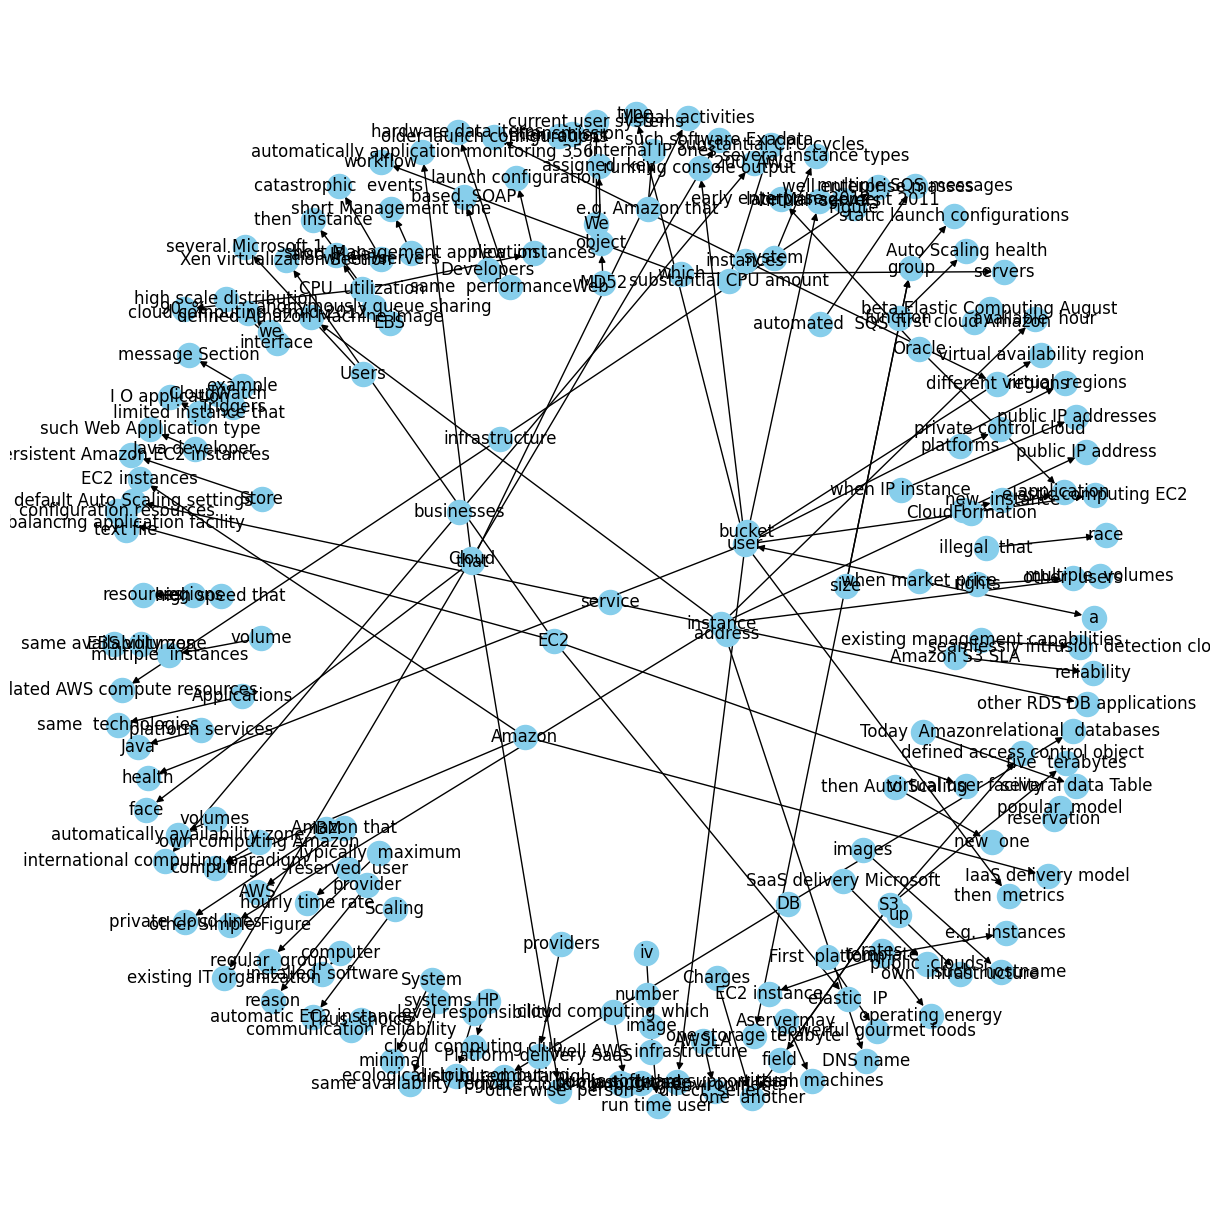

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#### Generate triplet csv files for whole TB

In [ ]:
def extract_kg(input_file_name):
  doc = docx.Document(input_file_name)
  coref_text = coref_resolve(getText(doc))
  compound_text = compound_to_simple(coref_text)

  cleaned = []
  for i in range(len(compound_text)):
    t = compound_text[i].replace('\n','')
    t = t.replace('\xa0','')
    cleaned.append(t)

  entity_pairs = []
  relations = []
  for i in tqdm(cleaned):
    entity_pairs.append(get_entities(i))
    r = get_relation(i)
    if r:
      relations.append(r)

    # extract subject
  source = [i[0] for i in entity_pairs]

  # extract object
  target = [i[1] for i in entity_pairs]
  rel = [r for r in relations]

  kg_df = pd.DataFrame({'source':source, 'edge':relations, 'target':target})

  kg_df['source'] = kg_df['source'].replace('', np.nan)
  kg_df['source'] = kg_df['source'].replace(' ', np.nan)
  kg_df['target'] = kg_df['target'].replace('', np.nan)
  kg_df['target'] = kg_df['target'].replace(' ', np.nan)
  kg_df['edge'] = kg_df['edge'].replace(' ', np.nan)
  kg_df['edge'] = kg_df['edge'].replace('', np.nan)
  
  df = kg_df.dropna(axis="rows")

  y = input_file_name.split('/')[-1].split('.')[0]
  output_filepath = '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/{}.csv'.format(y)
  df.to_csv(output_filepath)

In [ ]:
x = 1
input_pattern = '/content/drive/MyDrive/MSCS Project/CS298_spring23/data/docx/{}-*.docx'.format(x)
input_filepaths = glob.glob(input_pattern)

In [ ]:
for i in range(len(input_filepaths)):
  extract_kg(input_filepaths[i])

<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 34/34 [00:00<00:00, 52.55it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 6/6 [00:00<00:00, 45.07it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 13/13 [00:00<00:00, 30.44it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 42/42 [00:00<00:00, 49.33it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 38/38 [00:00<00:00, 48.70it/s]
<i

In [ ]:
for x in range(2, 12):
  input_pattern = '/content/drive/MyDrive/MSCS Project/CS298_spring23/data/docx/{}-*.docx'.format(x)
  input_filepaths = glob.glob(input_pattern)
  for i in range(len(input_filepaths)):
    extract_kg(input_filepaths[i])

<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 109/109 [00:02<00:00, 48.53it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 29/29 [00:00<00:00, 48.57it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 54/54 [00:01<00:00, 53.34it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 83/83 [00:01<00:00, 52.33it/s]
<ipython-input-2-0dcb42f87711>:14: DeprecationWarning: NotImplemented should not be used in a boolean context
  res = list(filter((None).__ne__, res1))
100%|██████████| 28/28 [00:00<00:00, 49.88it/s

### Merge into one csv file
###### triplets from each chapter merge into one file for analysis

In [ ]:
import glob
csvfilepath = '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/'
csv_files = glob.glob(csvfilepath+'*.{}'.format('csv'))
csv_files

['/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-5.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-1.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-8.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-9.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-6.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-4.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-intro.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-2.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-3.csv',
 '/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/tb_kg_spacy/1-7.csv',
 '/content/drive/MyDrive/M

In [ ]:
import pandas as pd
df_concat = pd.concat([pd.read_csv(f) for f in csv_files ], ignore_index=True)
df_concat.tail()


,Unnamed: 0,source,edge,target
5251,36,where TCP port B,assume,security group
5252,42,user,1,security rule
5253,46,instance Wizard,Use,key value Figures
5254,56,Linux port numbers,assigned by,only root
5255,57,called services,maps friendly,textual port numbers


In [ ]:
df_concat_select.head()

,source,edge,target
0,computing,based on,computing paradigm ethics
1,multiple services,stored on multiple,several organizations
2,Systems,span,multiple security process
3,border,becomes,accountability
4,something,make,case


In [ ]:
df_concat_select = df_concat[['source','edge','target']]

In [ ]:
df_filtered = df_concat_select[~df_concat_select['edge'].astype(str).str.isnumeric()]


In [ ]:
df_filtered

,source,edge,target
0,computing,based on,computing paradigm ethics
1,multiple services,stored on multiple,several organizations
2,Systems,span,multiple security process
3,border,becomes,accountability
4,something,make,case
...,...,...,...
5250,other rule,blocked,otherwise security instance
5251,where TCP port B,assume,security group
5253,instance Wizard,Use,key value Figures
5254,Linux port numbers,assigned by,only root


In [ ]:
for index, row in df_concat_select.iterrows():
    edge = row['edge']
    if edge.isnumeric():
      print(edge, row['edge'])

1 1
291 291
1 1
1 1
1 1
35 35
1 1
1 1
1 1
1 1
1 1
1 1


some filtering are applied to remove special characters or entities that do not make sense -- too short

In [ ]:
df = df_filtered
df['edge'] = df['edge'].str.lower()

<ipython-input-33-4fa46531b8f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['edge'] = df['edge'].str.lower()


In [ ]:
filter_cond = []
for index, row in df.iterrows():
    t = row['target']
    s = row['source']
    if len(t) <2 or len(s) <2:
      filter_cond.append(index)


In [ ]:
df2 = df.drop(filter_cond)


In [ ]:
df

,source,edge,target
0,computing,based on,computing paradigm ethics
1,multiple services,stored on multiple,several organizations
2,Systems,span,multiple security process
3,border,becomes,accountability
4,something,make,case
...,...,...,...
5250,other rule,blocked,otherwise security instance
5251,where TCP port B,assume,security group
5253,instance Wizard,use,key value Figures
5254,Linux port numbers,assigned by,only root


In [ ]:
df2.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_full.csv')

In [ ]:
filter_ind = []
for index, row in df2.iterrows():
    t = row['target']
    s = row['source']
    if '%' in t or '%' in s or '(' in t or '(' in t:
      filter_ind.append(index)

In [ ]:
df3 = df2.drop(filter_ind)


In [ ]:
df4.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_full.csv')

In [ ]:
df4= df3

In [ ]:
for index, row in df3.iterrows():
  e = row['edge']
  if len(e.split(" ")) > 1:
    row['edge'] = "_".join(e.split(" "))

In [ ]:
index_cond = set()


In [ ]:
for index, row in df_clean.iterrows():
    e = row['edge']
    # s = row['source']
    if '\' in e :
      print(index,e)

In [ ]:
df5v = df4.drop(4275)

In [ ]:
df.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_full.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_full.csv')

,Unnamed: 0,source,edge,target
0,0,computing,based_on,computing paradigm ethics
50,50,use,contributes_to,data
100,100,Eastern United which,troubled_by,electrical utility power storm
150,150,Cloud computing,uses,elastic Internet services
200,200,Last systems,shielded_from,often system architecture
...,...,...,...,...
4800,4800,same scheduling algorithms,coordinated_with,memory management
4850,4850,when communication trust,based_on_past,mobile device
4900,4900,information,report,channels strategy
4950,4950,malicious nodes,see,minority


In [ ]:
strtest = "a  b"
strtest.split("  ")

['a', 'b']

In [ ]:
for index, row in df.iterrows():
  s = row['source']
  t = row['target']
  if len(s.split("  ")) > 1:
    row['source'] = "".join(s.split("  "))
  if len(t.split("  ")) > 1:
    row['target'] = "".join(t.split("  "))

In [ ]:
remove_row = []
# discuss several to discuss
for index, row in df.iterrows():
    e = row['edge']
    if row['edge'] == 'discuss_several':
      row['edge'] = 'discuss'
  # remove the
    elif row['edge'] == 'the' or row['edge'] == 'ls' or row['edge'] == 'ssh10' or row['edge'] == 'nfswas' or row['edge'] == 'at' or row['edge'] == 'vms' or row['edge'] == 'in' or row['edge'] == 'cwnd' or row['edge'] == 'conf' or row['edge'] == 'fact':
      remove_row.append(index)

  # lose and loses
    elif row['edge'] == 'lose':
        row['edge'] = 'loses'

  # remove if len=1
    elif len(e) == 1:
      remove_row.append(index)

    elif row['edge'] == 'runmultiple':
        row['edge'] = 'run_multiple'
  #onlymanifest_under_extreme
    elif row['edge'] == 'onlymanifest_under_extreme':
          row['edge'] = 'manifest_under_extreme'

  #waits , waits_for
    elif row['edge'] == 'waits_for':
            row['edge'] = 'waits'
    elif row['edge'] == 'maps_friendly':
            row['edge'] = 'map'


In [ ]:
df.drop(remove_row)

,Unnamed: 0.1,Unnamed: 0,source,edge,target
0,0,0,computing,based_on,computing paradigm ethics
1,1,1,multiple services,stored_on_multiple,several organizations
2,2,2,Systems,span,multiple security process
3,3,3,border,becomes,accountability
4,4,4,something,make,case
...,...,...,...,...,...
5012,5012,5076,other rule,blocked,otherwise security instance
5013,5013,5077,where TCP port B,assume,security group
5014,5014,5078,instance Wizard,use,key value Figures
5015,5015,5079,Linux port numbers,assigned_by,only root


In [ ]:
df = df[['source','edge','target']]

In [ ]:
df['edge'].value_counts()[:20]

has             107
have            100
uses             82
allows           72
supports         59
used             58
use              55
based_on         53
requires         48
is               38
means            36
consists_of      35
discuss          33
shows            32
provides         31
allow            31
discussed_in     30
require          28
support          25
presented_in     24
Name: edge, dtype: int64

In [ ]:
df1 = df.head(1000)

In [ ]:
df1.tail()

,source,edge,target
995,Amazon,reshapes,computing
996,first cloud Amazon,announced,beta Elastic Computing August
997,Figure,shows,late Management 2011
998,instance,created,defined Amazon Machine image
999,image,includes,run time user


In [ ]:
df2 = df[1000:2000]

In [ ]:
df3 = df[2000:3000]

In [ ]:
df4 = df[3000:4000]

In [ ]:
df4 = df[4000:]

In [ ]:
df4.tail()

,source,edge,target
5012,other rule,blocked,otherwise security instance
5013,where TCP port B,assume,security group
5014,instance Wizard,use,key value Figures
5015,Linux port numbers,assigned_by,only root
5016,called services,map,textual port numbers


In [ ]:
df1.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_1.csv')
df2.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_2.csv')
df3.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_3.csv')
df4.to_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/spacy_4.csv')

### Comparing GCP/spacy with TEI: How many are identified in TEI?

In [ ]:
import pandas as pd

In [ ]:
tei_df = pd.read_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/TEI_kg.csv', header=None)

In [ ]:
gcp_df = pd.read_csv('/content/drive/MyDrive/MSCS Project/CS298_spring23/results/KG_extraction/GCP_kg.csv')

In [ ]:
gcp_df.head(10)

,n
0,"{""uri"":LC}"
1,"{""uri"":abstraction}"
2,"{""uri"":clock}"
3,"{""uri"":clocks}"
4,"{""uri"":event}"
5,"{""uri"":clock condition}"
6,"{""uri"":absence}"
7,"{""uri"":events}"
8,"{""uri"":event e}"
9,"{""uri"":message}"


In [ ]:
node_gcp = set()
for index, row in gcp_df.iterrows():
  e = row[0]
  t = e.split(':')[1][:-1]
  node_gcp.add(t)

In [ ]:
len(node_gcp)

9380

In [ ]:
node = set()
for index, row in tei_df.iterrows():
  s = row[0]
  t = row[2]

  node.add(s)
  node.add(t)

In [ ]:
len(node)

1187

In [ ]:
node_spacy = set()
edge_spacy = set()
for index, row in df.iterrows():
  s = row['source']
  t = row['target']
  e = row['edge']

  node_spacy.add(s)
  node_spacy.add(t)
  edge_spacy.add(e)

In [ ]:
df['edge'].describe()

count     5017
unique    2033
top        has
freq       107
Name: edge, dtype: object

In [ ]:
df['source'].value_counts().head(50)

that                111
we                   93
system               73
We                   52
user                 40
systems              37
us                   33
applications         30
VMM                  29
users                29
which                26
number               24
algorithm            22
server               18
application          18
nodes                17
task                 17
service              16
data                 16
This                 16
cloud                15
servers              15
it                   15
management           15
one                  15
model                15
networks             14
Figure               14
strategy             14
master               14
paper                13
thread               13
infrastructure       12
network              12
this                 12
Next  we             11
Table                11
process              11
OS                   11
Xen                  11
client               11
code            

In [ ]:
df['target'].value_counts().head(50)

the                    76
system                 23
data                   20
which                  17
Figure                 15
cloud                  13
Section                11
case                   11
one                    10
network                10
same  time             10
one  another            9
cloud computing         9
resources               8
client                  8
processes               7
file                    7
VM                      7
time                    7
example                 6
Internet                6
node                    6
same                    6
messages                6
value                   6
host                    6
user                    6
channel                 6
servers                 6
instance                5
virtual  machine        5
request                 5
that                    5
nodes                   5
order                   5
tasks                   5
Table                   5
vertices                5
other  appli

In [ ]:
diff_node = set()
for n in node:
  if n in node_spacy and n not in node_gcp:
  # if n in node:
    diff_node.add(n)

In [ ]:
len(diff_node)

10

In [ ]:
for n in diff_node:
  print(n, end =", ")

average conversion time, vector processing, goals, EC2 instances, FIFO delivery, Avast antivirus software, Firewalls, FORWARD rule, 7.12 epidemic algorithms, response time, 

In [ ]:
diff_node_2 = set()
for n in node:
  if n not in node_spacy and n in node_gcp:
  # if n in node:
    diff_node_2.add(n)

In [ ]:
len(diff_node_2)

189

In [ ]:
for n in diff_node_2:
  print(n, end =", ")

buffer space, Elastic Beanstalk, evolution, resource allocation, risks, MAESTRO, security rules, Cloud applications, Workflow verification, Image processing, user concerns, Control granularity, back-end systems, Ring deprivileging, compute, cloud applications, optimization problem, vBlades, monitors, Web page, Chromebook, System heterogeneity, Privacy concerns, application controllers, benefits, Google Analytics, Scaling transparency, Linux AMI, scheduling policies, Mashup Container, network resource management, Petri nets, Cloud controller, Context switching, VM models, clock rate, fabric controller, trust indexes, implications, Ring compression, Cell storage, Toolstack, Cloud resource management, operating efficiency, ZooKeeper, Overlay networks, HTTP tunneling, Software licensing, Paravirtualization, EC2 Request Instance Wizard, entities, Itanium, system design strategy, Capacity allocation, transport layer, Trojan, Address space compression, Journal storage, VMX nonroot, Evaluation

In [ ]:
'cloud computing' in node_gcp

True

In [ ]:
overlap_node = set()
for n in node_spacy:
  if n not in node:
  # if n in node:
    overlap_node.add(n)

In [ ]:
overlap_node = set()
for n in node_gcp:
  if n not in node:
    overlap_node.add(n)

In [ ]:
len(overlap_node)

6625

In [ ]:
for n in overlap_node:
  print(n, end =", ")

many  hands, far  matter, concurrent  threads, reasonable aWeb site, scientific power trend, answers, same  size, versatility, repeatedly  replicas, output, bit Linux AWS, both, Support, 276, standby  mode, AppSettings, Paxos protocol, otherwise  person, spectrum allocation rules, 17.59 Linpack benchmark, List String, acids, when information behavior, three safety properties, dynamic trust that, differently  Section, same  platform, immediately  several, DNS name, SMS, dynamic y−z domains, basic cloud functions, large Performance Computing NERSC, only channels information, higher clock signals, image, Several  properties, database, centric data control, additional  problems, broad  categories, CPU  utilization, min fairness criterion, new  value, control, Database Service, partially user responsibility, global  behavior, hypervisormust, inodes, exclusively  data, periodically GFS file server, marked  graphs, disk, Indeed  we, human  knowledge, actual  service, second  event, multiple C

In [ ]:
len(overlap_node)

9097

In [ ]:
for n in overlap_node:
  print(n, end =", ")

failure scenarios, price πu, NC, C/C++, arc, answers, Grafinkel, putObject, versatility, output, both, request message, Support, 276, workload patterns, Random, spectrum allocation rules, TigerShark, rectangular, auditability, 3.1, site licenses, workers, capabilities, prediction, multipath fading, VMMuses, SDK.3 Create, Facebook, warping mechanism, 133, XML, DNS name, SMS, William of Ockham, −60, port types, application development, image, database, ki kmin − 1, Vi (t, KBto 1MB, synchronization, AWS instances, UDP, keyboard, union, Stanford, master server, 7.28, building, control, AmazonS3Client s3, 153, compute units, Nets, hypervisormust, 14, 1969, inodes, permissions, application., 60,000, transport protocol daemon, disk, pj, Princeton, allKeys, gigabit Ethernet, TCP connection, StdXL, block storage, 6.40, virtual machine functions, 68,339, protein alignment, b instruction, dependency, University of California at Los Angeles, paradigms, neutrons, service factor, rk, looms, theWeb, 